In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.insert(0, '../')

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import subprocess
import pickle
from copy import copy
from easydict import EasyDict as edict

from sklearn import metrics
from sklearn.metrics import classification_report

from traindet import get_class_preds, build_confusion_matrix, calc_detection
import traindet.config as cfg
from traindet.utils import RealDataset, load_model, parse_log

In [5]:
def save_text(text, filepath):
    with open(filepath, 'w') as f:
        f.write(text)

# Evaluation

In [5]:
val_ds = RealDataset(train=False)

## mAP
The mAP can be extracted from the training logs.

In [6]:
models = cfg.used_model_names
prefixes = [
    '../checkpoints/ssd300/transfer_300_ssd_300_vgg16_atrous_coco',
    '../checkpoints/ssd512/transfer_512_ssd_512_resnet50_v1_coco',
    '../checkpoints/yolo416/transfer_416_yolo3_darknet53_coco',
    '../checkpoints/faster_rcnn/transfer_faster_rcnn_resnet50_v1b_coco'
]
out = {}
epochs = {}
for model, prefix in zip(models, prefixes):
    epochs[model], out[model] = parse_log(prefix)

In [7]:
index = copy(cfg.classes)
index.append('mAP')
map_df = pd.DataFrame(out, index=index)
map_df.columns = cfg.formated_model_names
index = copy(cfg.formated_classes)
index.append('mAP')
map_df.index = index
map_df

,SSD300,SSD512,YOLOv3-416,Faster R-CNN
Tray,0.982143,1.000000,0.993939,1.000000
Dosing Nozzle,1.000000,0.987879,1.000000,0.998145
Button Pad,0.909091,1.000000,1.000000,1.000000
Part 01,1.000000,1.000000,0.732468,0.987603
Part 02,1.000000,1.000000,0.896970,1.000000
Part 03,0.909091,1.000000,0.797980,0.990909
mAP,0.966721,0.997980,0.903559,0.996110


In [8]:
for key, val in epochs.items():
    print(f'{key} best mAP reached on epoch {val}.')

ssd300 best mAP reached on epoch 69.
ssd512 best mAP reached on epoch 97.
yolo416 best mAP reached on epoch 84.
frcnn best mAP reached on epoch 25.


In [9]:
save_text(map_df.round(3).to_latex(), '../outputs/map_table.txt')

## Classification Metrics

Load predictions obtained by running `traindet.main.py`.

In [10]:
with open('../gen_data/predictions.pkl', 'rb') as f:
    data = pickle.load(f)

In [11]:
data.keys()

dict_keys(['ssd300', 'ssd512', 'yolo416', 'frcnn'])

In [12]:
data['ssd300'].keys()

dict_keys(['predictions', 'labels'])

## Chosing the classification threshholds
Score values may not be equivalent among different models, in order to choose the ideal threshold of each model the number of false positive detections and the number of false negative detections were chosen. Those numbers were converted in a single metric by the sum.

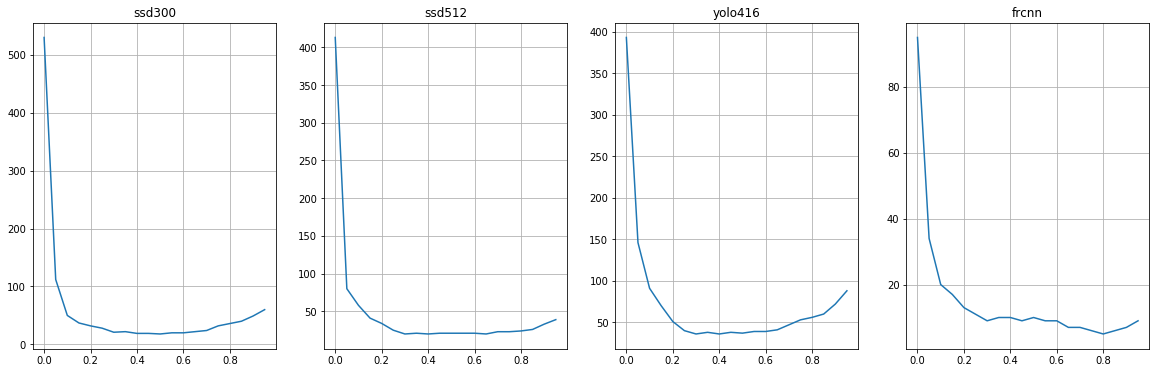

In [13]:
curves = edict()
ths = np.arange(0, 1, 0.05)
for model, results in data.items():
    curves[model] = []
    for th in ths:
        out = calc_detection(results['labels'], results['predictions'], th=th, iou_th=0.5)
#         out = [1/(o + 0.1) for o in out]
#         curves[model].append((2 * out[0] * out[1])/(sum(out)))
        curves[model].append(sum(out))

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 6))
opt_ths = edict()
for ax, (model, vals) in zip(axs, curves.items()):
    ax.plot(ths, vals)
    ax.set_title(model)
    ax.grid()
    a = np.array(vals)
    idx = np.argwhere(a == np.min(a))[-1].item()
    opt_ths[model] = ths[idx]

optimal thresholds

In [14]:
opt_ths

{'ssd300': 0.5, 'ssd512': 0.65, 'yolo416': 0.4, 'frcnn': 0.8}

### Fixed classification threshold of 0.5
First, the classification metrics and confusion matrices wera analyzed with a unified IOU and detection threshold of 0.5 for all models.

In [15]:
target_names = copy(cfg.classes)
target_names.append('Undetected')

# Calculate class predictions and labels
class_preds = edict()
for model, results in data.items():
    class_preds[model] = edict()
    class_preds[model].preds, class_preds[model].labels = get_class_preds(results['labels'], results['predictions'], th=0.5, iou_th=0.5)
   
metrics_names = ['Precision', 'Recall', 'F1-score', 'Accuracy']
out = edict()
conf_matrices = edict()
for model, val in class_preds.items():
    out[model] = []
    out[model].append(metrics.precision_score(val.labels, val.preds, average='weighted'))
    out[model].append(metrics.recall_score(val.labels, val.preds, average='weighted'))
    out[model].append(metrics.f1_score(val.labels, val.preds, average='weighted'))
    out[model].append(metrics.accuracy_score(val.labels, val.preds))
    conf_matrices[model] = build_confusion_matrix(val.labels, val.preds, cfg.classes)

/home/cezar/Programs/anaconda3/envs/mx10/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/cezar/Programs/anaconda3/envs/mx10/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [16]:
out

{'ssd300': [0.9944508670520231,
  0.930635838150289,
  0.9600036485797202,
  0.930635838150289],
 'ssd512': [0.9826870092931198,
  0.9421965317919075,
  0.9610940036110509,
  0.9421965317919075],
 'yolo416': [0.9588212044859444,
  0.8323699421965318,
  0.8702068476119114,
  0.8323699421965318],
 'frcnn': [0.9885572726200307,
  0.976878612716763,
  0.9822971327264075,
  0.976878612716763]}

In [17]:
metrics.precision_score(class_preds.ssd300.labels, class_preds.ssd300.preds, average='micro')

0.930635838150289

In [18]:
metrics.recall_score(class_preds.ssd300.labels, class_preds.ssd300.preds, average='micro')

0.930635838150289

In [19]:
def format_cm(cm):
    cm = copy(cm)
    l = cfg.formated_classes + ['Undetected', 'Total']
    cm.columns = l
    cm.index = l
    cm.drop('Total', axis=1, inplace=True)
    return cm

In [20]:
metrics_df = pd.DataFrame(out, index=metrics_names)
metrics_df.columns = cfg.formated_model_names
metrics_df0 = metrics_df
metrics_df0

,SSD300,SSD512,YOLOv3-416,Faster R-CNN
Precision,0.994451,0.982687,0.958821,0.988557
Recall,0.930636,0.942197,0.832370,0.976879
F1-score,0.960004,0.961094,0.870207,0.982297
Accuracy,0.930636,0.942197,0.832370,0.976879


In [37]:
save_text(metrics_df0.round(3).to_latex(), '../outputs/metrics.txt')

In [22]:
save_text(format_cm(conf_matrices['ssd300']).to_latex(), '../outputs/cm_ssd300.txt')
conf_matrices['ssd300']

,tray,dosing_nozzle,button_pad,part1,part2,part3,Undetected,Total
tray,37,0,1,0,0,0,4,42
dosing_nozzle,0,47,0,0,0,0,1,48
button_pad,0,0,24,0,0,0,0,24
part1,0,0,0,19,0,0,0,19
part2,0,0,0,0,17,0,4,21
part3,0,0,0,0,0,17,2,19
Undetected,0,0,0,0,0,0,0,0
Total,37,47,25,19,17,17,11,173


In [23]:
save_text(format_cm(conf_matrices['ssd512']).to_latex(), '../outputs/cm_ssd512.txt')
conf_matrices['ssd512']

,tray,dosing_nozzle,button_pad,part1,part2,part3,Undetected,Total
tray,38,0,1,0,0,0,3,42
dosing_nozzle,0,48,0,0,0,0,0,48
button_pad,0,0,24,0,0,0,0,24
part1,0,1,0,17,0,0,1,19
part2,0,0,0,0,19,0,2,21
part3,0,0,0,1,0,17,1,19
Undetected,0,0,0,0,0,0,0,0
Total,38,49,25,18,19,17,7,173


In [24]:
save_text(format_cm(conf_matrices['yolo416']).to_latex(), '../outputs/cm_yolo416.txt')
conf_matrices['yolo416']

,tray,dosing_nozzle,button_pad,part1,part2,part3,Undetected,Total
tray,40,0,2,0,0,0,0,42
dosing_nozzle,0,48,0,0,0,0,0,48
button_pad,0,0,24,0,0,0,0,24
part1,0,0,0,6,0,3,10,19
part2,0,0,0,0,13,2,6,21
part3,0,0,0,0,0,13,6,19
Undetected,0,0,0,0,0,0,0,0
Total,40,48,26,6,13,18,22,173


In [25]:
save_text(format_cm(conf_matrices['frcnn']).to_latex(), '../outputs/cm_frcnn.txt')
conf_matrices['frcnn']

,tray,dosing_nozzle,button_pad,part1,part2,part3,Undetected,Total
tray,42,0,0,0,0,0,0,42
dosing_nozzle,0,48,0,0,0,0,0,48
button_pad,0,0,24,0,0,0,0,24
part1,0,1,0,18,0,0,0,19
part2,0,0,0,0,20,0,1,21
part3,0,0,0,1,0,17,1,19
Undetected,0,0,0,0,0,0,0,0
Total,42,49,24,19,20,17,2,173


In [26]:
conf_matrices0 = conf_matrices

### With different thresholds per model
Now, the confusion classification metrics and confusion matrices with the calculated threshold.

It can be seen that after adapting the threshold the number of undetected examples was greatly reduced, without hurting the classification performance.

In [27]:
# Calculate class predictions and labels
class_preds = edict()
for model, results in data.items():
    class_preds[model] = edict()
    class_preds[model].preds, class_preds[model].labels = get_class_preds(results['labels'], results['predictions'], th=opt_ths[model], iou_th=0.5)
   
metrics_names = ['Precision', 'Recall', 'F1-score', 'Accuracy']
out = edict()
conf_matrices = edict()
for model, val in class_preds.items():
    out[model] = []
    out[model].append(metrics.precision_score(val.labels, val.preds, average='macro'))
    out[model].append(metrics.recall_score(val.labels, val.preds, average='macro'))
    out[model].append(metrics.f1_score(val.labels, val.preds, average='macro'))
    out[model].append(metrics.accuracy_score(val.labels, val.preds))
    conf_matrices[model] = build_confusion_matrix(val.labels, val.preds, cfg.classes)

In [28]:
metrics_df = pd.DataFrame(out, index=metrics_names)
metrics_df.columns = cfg.formated_model_names
metrics_df1 = metrics_df
metrics_df1

,SSD300,SSD512,YOLOv3-416,Faster R-CNN
Precision,0.851429,0.843492,0.794206,0.857143
Recall,0.794911,0.779583,0.689223,0.827784
F1-score,0.820708,0.809228,0.720638,0.841861
Accuracy,0.930636,0.919075,0.861272,0.976879


In [29]:
metrics_df1 - metrics_df0

,SSD300,SSD512,YOLOv3-416,Faster R-CNN
Precision,-0.143022,-0.139195,-0.164615,-0.131414
Recall,-0.135724,-0.162614,-0.143147,-0.149095
F1-score,-0.139296,-0.151866,-0.149569,-0.140436
Accuracy,0.000000,-0.023121,0.028902,0.000000


In [30]:
with open('../gen_data/thresholds.pkl', 'wb') as f:
    pickle.dump(opt_ths, f)

In [31]:
dets = {}
ths = np.arange(0, 1, 0.05)
for model, results in data.items():
    dets[model] = {}
    for th in ths:
        out = calc_detection(results['labels'], results['predictions'], th=th, iou_th=0.5)
#         out = [1/(o + 0.1) for o in out]
#         curves[model].append((2 * out[0] * out[1])/(sum(out)))
        dets[model][th] = out

In [32]:
pd.DataFrame(dets)

,ssd300,ssd512,yolo416,frcnn
0.00,"(0, 530)","(0, 413)","(1, 392)","(1, 94)"
0.05,"(1, 111)","(2, 78)","(1, 145)","(1, 33)"
0.10,"(2, 48)","(2, 56)","(3, 88)","(1, 19)"
0.15,"(2, 35)","(2, 39)","(5, 65)","(1, 16)"
0.20,"(5, 27)","(2, 32)","(7, 44)","(1, 12)"
0.25,"(5, 23)","(2, 23)","(11, 29)","(1, 10)"
0.30,"(6, 15)","(2, 18)","(15, 21)","(1, 8)"
0.35,"(8, 14)","(5, 16)","(19, 19)","(2, 8)"
0.40,"(9, 10)","(7, 13)","(22, 14)","(2, 8)"
0.45,"(9, 10)","(9, 12)","(26, 12)","(2, 7)"


In [33]:
opt_ths

{'ssd300': 0.5, 'ssd512': 0.65, 'yolo416': 0.4, 'frcnn': 0.8}

## Benchmarks

In [29]:
with open('../gen_data/benchmarks.pkl', 'rb') as f:
    times = pickle.load(f)

In [30]:
# pd.DataFrame({key: val for key, val in times['GPU'].items()})

In [31]:
# pd.DataFrame({key: val[1:] for key, val in times['CPU'].items()})

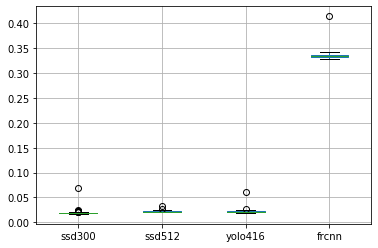

In [40]:
pd.DataFrame(times['GPU']).boxplot()

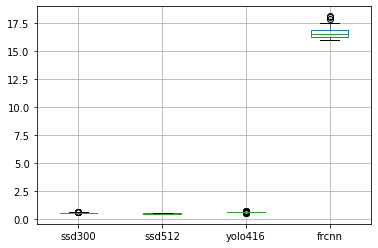

In [41]:
pd.DataFrame(times['CPU']).boxplot()

In [36]:
tdf = pd.DataFrame(times).applymap(lambda x: 1/np.mean(x)).T[cfg.used_model_names]
tdf.columns = cfg.formated_model_names

In [37]:
tdf

,SSD300,SSD512,YOLOv3-416,Faster R-CNN
GPU,52.330965,45.813648,44.651485,2.981578
CPU,1.724425,2.021954,1.588788,0.060284


In [39]:
save_text(tdf.round(3).to_latex(), '../outputs/benchmark.txt')

In [38]:
pd.DataFrame(times).applymap(lambda x: len(x)).T

,frcnn,ssd300,ssd512,yolo416
GPU,110,110,110,110
CPU,110,110,110,110


In [46]:
tdf = pd.DataFrame(times)

In [47]:
np.mean(tdf.iloc[0,0])

0.8154554934728713